In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


In [2]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

Ingeniería de características

In [3]:
def n_nonprod(df):
    x = df.loc[(df['activity'] == 'Nonproduction')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_nonprod'}).reset_index()
    return x

def len_nonprod(df):
    x = df.loc[df['activity'] == 'Nonproduction',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_nonprod'}).reset_index()
    return x

def n_input(df):
    x = df.loc[(df['activity'] == 'Input')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_input'}).reset_index()
    return x

def len_input(df):
    x = df.loc[df['activity'] == 'Input',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_input'}).reset_index()
    return x

def n_replace(df):
    x = df.loc[(df['activity'] == 'Replace')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_replace'}).reset_index()
    return x

def len_replace(df):
    x = df.loc[df['activity'] == 'Replace',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_replace'}).reset_index()
    return x

def n_remove(df):
    x = df.loc[(df['activity'] == 'Remove/Cut')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_remove'}).reset_index()
    return x

def len_remove(df):
    x = df.loc[df['activity'] == 'Remove/Cut',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_remove'}).reset_index()
    return x

def n_words(df):
    x = df[['id','word_count']].groupby('id').last()
    return x

def max_word(df):#-0.004234
    x = df[['id','word_count']].groupby('id').max().rename(columns = {'word_count':'max_word'})
    return x 

def act_time(df):
    x = df.groupby('id')['action_time'].sum().reset_index().rename(
        columns = {'action_time':'act_time'})
    return x
def writing_time(df):
    x = pd.DataFrame(df.groupby('id').last()['up_time']).reset_index().rename(columns={'up_time':'writing_time'})
    return x

def n_events(df):
    x = df[['id','event_id']].groupby('id').count().reset_index().rename(columns={'event_id':'n_events'})
    return x


def punct(df):
    x = df.loc[df.down_event.isin(['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']),['id','down_event']].groupby('id').count().rename(columns={'down_event':'punct'})
    return x
    
#varianza del proceso,dividir el tiempo de 5 a 10 intervalos y ver el num medio d frases producidas
def cuenta_frases(df):
    x = df.loc[df.down_event == '.','id'].count()
    return x
def numfrases_intervalo(df):
    dic = []
    for nombre, datos in df.groupby('id'):
        dic.append(np.min([cuenta_frases(h) for h in np.array_split(datos,indices_or_sections = 2)]))
    x = pd.DataFrame({'id': df.id.unique(),'numfrases_intervalo':dic})
    return x
    

#varianza del proceso,dividir el tiempo de 5 a 10 intervalos y ver el num max de signos de puntuación escritos
def cuenta_punct(df):
    x = df.loc[df.down_event.isin(['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']),'id'].count()
    return x
def numpunct_intervalo(df):
    dic = []
    for nombre, datos in df.groupby('id'):
        dic.append(np.max([cuenta_punct(h) for h in np.array_split(datos,indices_or_sections = 5)]))
    x = pd.DataFrame({'id': df.id.unique(),'numpunct_intervalo':dic})
    return x

def cursor_position_mean(df):
    x = df[['id','cursor_position']].groupby('id').mean().rename(
         columns = {'cursor_position':'cursor_position_mean'}).reset_index()
    return x

def n_remove2(df):
    x = df.loc[df.down_event.isin(['Backspace','Delete']),['id','down_event']].groupby('id').count().rename(columns={'down_event':'n_remove2'})
    return x

def n_parrafos(df):
    x = df.loc[df.down_event=='Enter',['id','down_event']].groupby('id').count().rename(columns={'down_event':'n_parrafos'})
    return x
def n_dropenter(df):
    x = df.loc[(df['text_change'] == '\n') & (df['activity'] == 'Remove/Cut'),['id','text_change']].groupby('id').count().rename(columns={'text_change':'n_dropenter'}) 
    return x
def n_parrafos2(df):
    dataframe = train_scores.drop('score',axis=1).merge(n_parrafos(train_logs,on='id',how='left')).merge(n_dropenter,on='id',how='left').fillna(0) 
    x = dataframe['n_parrafos'] - dataframe['n_dropenter']
    return x

def doblenter(df):
    texto = train_logs.loc[train_logs.down_event=='Enter',['id','event_id','down_event']].groupby('id')
    dic = {'id':[],'num_parrafos':[]}
    for nombre, datos in texto:
        lista = [h for h in datos['event_id']]
        dic['id'].append(nombre)
        dic['num_parrafos'].append(np.sum([1 if ((h+1 in lista) and (h+2 not in lista)) else 0 for h in lista]))
    x = pd.DataFrame(dic)
    return x

def n_space(df):
    x = df.loc[df.down_event=='Space',['id','down_event']].groupby('id').count().rename(columns={'down_event':'n_space'})
    return x

def no_change(df):
    x = df.loc[df.text_change == 'NoChange',['id','text_change']].groupby('id').count().rename(columns = {'text_change':'num_nochange'})
    return x 
    
def cuenta_textchange(df):
    x = df.loc[df.activity == 'Replace','text_change'].reset_index(drop=True)
    return x 

def num_shift(df):
    x = df.loc[df.down_event == 'Shift',['id','down_event']].groupby('id').count().rename(columns = {'down_event':'num_shift'})
    return x

def cuenta_punct(df):
    x = df.loc[df.down_event.isin(['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']),'id'].count()
    return x
def numpunct_intervalo(df):
    dic = []
    for nombre, datos in df.groupby('id'):
        dic.append(np.max([cuenta_punct(h) for h in np.array_split(datos,indices_or_sections = 5)]))
    x = pd.DataFrame({'id': df.id.unique(),'numpunct_intervalo':dic})
    return x
def maxact_time(df):
    x = df.groupby('id')['action_time'].max().reset_index().rename(
        columns = {'action_time':'maxact_time'})
    return x


In [4]:
def DatFeatures(df):
    dataframe = n_input(df)
    features = [len_input,n_nonprod,len_nonprod,n_remove,len_remove,
               n_replace,len_replace,n_events,n_words,
                act_time,writing_time,punct,numfrases_intervalo,
                cursor_position_mean,n_remove2,n_parrafos,n_space,n_dropenter,
                no_change,num_shift,doblenter,numpunct_intervalo,maxact_time]
    
    for fun in features:
        prev_dat = fun(df).fillna(0)
        dataframe = dataframe.merge(prev_dat,on='id',how='left').fillna(0)
    dataframe['pausa'] = dataframe['writing_time'] - dataframe['act_time']
    dataframe['prop_pausa'] = dataframe['pausa']/dataframe['writing_time']
    dataframe['time_by_word'] = (dataframe['writing_time']/dataframe['word_count']).replace([np.inf, np.inf],500000)
    dataframe['productivity'] = dataframe['act_time']/dataframe['writing_time']*100
    dataframe['n_caracteres2'] = dataframe['n_input'] - dataframe['n_remove2']
    dataframe['n_parrafos2'] = dataframe['n_parrafos'] - dataframe['n_dropenter']
    dataframe = dataframe.drop(['n_parrafos','n_dropenter'],axis=1)
    return dataframe

In [5]:
test_features = DatFeatures(test_logs)
train_features = DatFeatures(train_logs)

In [6]:
X_train = train_features.drop('id',axis=1)
X_test = test_features.drop('id',axis=1)

In [7]:
from scipy.stats import skew,boxcox
from sklearn.preprocessing import PowerTransformer,StandardScaler
transformer = PowerTransformer()
X_transformed = pd.DataFrame(transformer.fit_transform(X_train))
X_transformed.columns = X_train.columns
X_test_transformed = pd.DataFrame(transformer.transform(X_test))
X_test_transformed.columns = X_test.columns

In [8]:
y = train_scores['score']
y

0       3.5
1       3.5
2       6.0
3       2.0
4       4.0
       ... 
2466    3.5
2467    4.0
2468    1.5
2469    5.0
2470    4.0
Name: score, Length: 2471, dtype: float64

**Random Forest**

In [16]:
from sklearn.model_selection import ParameterGrid, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor

estimators = range(1,150,5)
scores = []
cv = KFold()
for i in estimators :
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                n_estimators = i
             )
    sc = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc['test_score'].mean())
    
scores    

[0.9377370704601009,
 0.7137713339887517,
 0.6898099809505824,
 0.6812142454078712,
 0.6768855831794908,
 0.6750617698778449,
 0.6723264448185459,
 0.6724917398426935,
 0.6703584920460323,
 0.6702038449960279,
 0.6695914751648615,
 0.6676478704438622,
 0.6675631303090942,
 0.667104199700276,
 0.6670115960492483,
 0.6670307185863076,
 0.6668696562448313,
 0.6667198927621584,
 0.6668982570605286,
 0.6663136583256813,
 0.6663236308019258,
 0.6663675398763861,
 0.6664388306198709,
 0.6660134230048316,
 0.66575741549399,
 0.6656572503939784,
 0.6653793291467802,
 0.6650079146728054,
 0.665100795408098,
 0.6652975557577419]

In [18]:
features = range(1,X_transformed.shape[1]+1)
scores2 = []
for i in features :
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                max_features = i
             )
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2.append(-sc2['test_score'].mean())
    
scores2    

[0.684867929069543,
 0.676603073686241,
 0.6714287109632997,
 0.6713912957316376,
 0.6703638678423037,
 0.6712844964148352,
 0.6668150353137585,
 0.6678411194117733,
 0.6658751410412581,
 0.6683140603521192,
 0.6654675849277126,
 0.6660263025081932,
 0.6631369830930933,
 0.6664378674642241,
 0.6652120101109402,
 0.6675701646922372,
 0.6645884813386165,
 0.6657537470182507,
 0.6641499987987031,
 0.6606619430841176,
 0.6625711155840535,
 0.6654871262244217,
 0.6667293803220117,
 0.6672964372699489,
 0.665541150953212,
 0.6667513682546573,
 0.6647108982798811,
 0.6662597447431646]

In [21]:
max_depth = range(1,20,1)
scores3 = []
for i in max_depth :
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                max_depth = i
             )
    sc3 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores3.append(-sc3['test_score'].mean())
    
scores3  

[0.7882502129012463,
 0.7171555845537657,
 0.6954378637417481,
 0.6842324538295458,
 0.6759832511211785,
 0.6708746143239818,
 0.6681656864087371,
 0.6659368557712451,
 0.665963218424815,
 0.6665264705549233,
 0.6654650559505367,
 0.6664284243068183,
 0.6664357494101909,
 0.6659085735281746,
 0.6674051818269258,
 0.667124574504614,
 0.6673934890798741,
 0.6665040302078109,
 0.6665709751485971]

In [23]:
min_samplesplit = range(2,20,1)
scores4 = []
for i in min_samplesplit :
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                min_samples_split = i
             )
    sc4 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores4.append(-sc4['test_score'].mean())
    
scores4  

[0.6662597447431646,
 0.6673263966830505,
 0.6657976003065335,
 0.6662498405039007,
 0.6670957822641596,
 0.6660273877425861,
 0.6655913371899521,
 0.6658843297007336,
 0.6646535896514475,
 0.6648409443355552,
 0.6641598511382243,
 0.6646079020174859,
 0.6639890509193519,
 0.6640495394843321,
 0.6638275834796529,
 0.6636568172417814,
 0.6629547980097733,
 0.6631701303732762]

In [25]:
min_samplesleaf = range(2,20,1)
scores5 = []
for i in min_samplesleaf :
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                min_samples_leaf = i
             )
    sc5 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores5.append(-sc5['test_score'].mean())
    
scores5 

[0.6645346391279594,
 0.6631364710960321,
 0.6651249739345836,
 0.665740690948392,
 0.6646099780503766,
 0.6662109425111935,
 0.6665009798036373,
 0.6674352475525908,
 0.6678445964224462,
 0.6688652624618117,
 0.6692674419665331,
 0.6702922602695844,
 0.6708126401438438,
 0.6710957284344966,
 0.6718138452438127,
 0.6730108067371187,
 0.6733524742259266,
 0.674213269936471]

In [27]:
min_impuritydecrease = np.linspace(0,1,num=10)
scores6 = []
for i in min_impuritydecrease :
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                min_impurity_decrease = i
             )
    sc6 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores6.append(-sc6['test_score'].mean())
    
scores6 

[0.6662597447431646,
 0.7879619383992534,
 0.7882502129012462,
 0.7882502129012463,
 1.0027572228131856,
 1.0249474471183864,
 1.0249474471183864,
 1.0249474471183864,
 1.0249474471183864,
 1.0249474471183864]

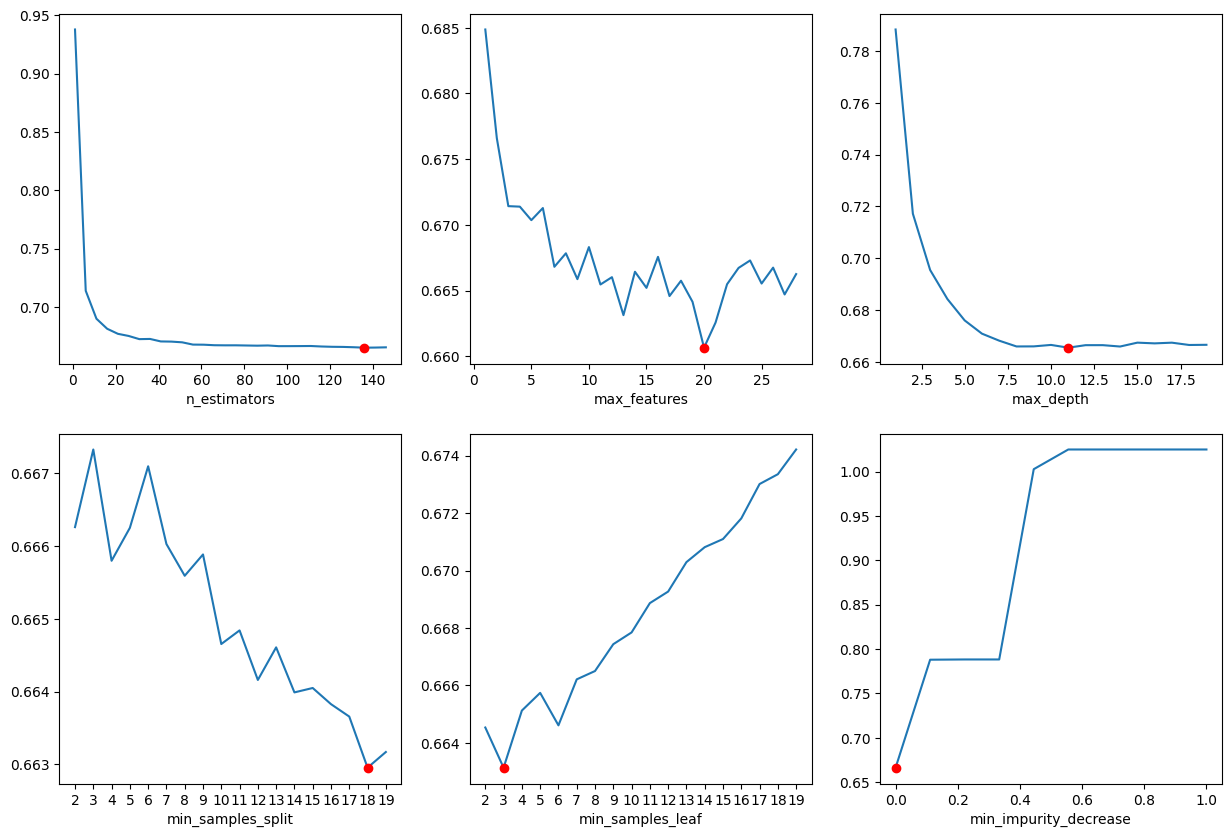

In [44]:
fig,axs = plt.subplots(nrows =2 ,ncols = 3,figsize=(15,10))
axs[0,0].plot(estimators,scores)
axs[0,0].plot(estimators[np.argmin(scores)],min(scores),'o',color='red')
axs[0,0].set_xlabel('n_estimators')
axs[0,1].plot(features,scores2)
axs[0,1].plot(features[np.argmin(scores2)],min(scores2),'o',color='red')
axs[0,1].set_xlabel('max_features')
axs[0,2].plot(max_depth,scores3)
axs[0,2].plot(max_depth[np.argmin(scores3)],min(scores3),marker='o',color = 'red')
axs[0,2].set_xlabel('max_depth')
axs[1,0].plot(min_samplesplit,scores4)
axs[1,0].set_xticks(min_samplesplit)
axs[1,0].set_xticks(min_samplesplit)
axs[1,0].set_xlabel('min_samples_split')
axs[1,0].plot(min_samplesplit[np.argmin(scores4)],min(scores4),'o',color='red')
axs[1,1].plot(min_samplesleaf,scores5)
axs[1,1].set_xticks(min_samplesleaf)
axs[1,1].plot(min_samplesleaf[np.argmin(scores5)],min(scores5),'o',color='red')
axs[1,1].set_xlabel('min_samples_leaf')
axs[1,2].plot(min_impuritydecrease,scores6)
axs[1,2].set_xlabel('min_impurity_decrease')
axs[1,2].plot(min_impuritydecrease[np.argmin(scores6)],min(scores6),'o',color='red')

In [54]:
from sklearn.model_selection import ParameterGrid, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
cv = KFold()
param_grid = ParameterGrid(
                {'n_estimators': [141],
                 'max_features': [8,15,20],
                 'max_depth'   : [8,9,10],#descartamos max_depth = None pues se produce mucho sobreajuste
                 'min_samples_split': [12,16,19],
                 'min_samples_leaf':[3,4,6]
                }
             )
resultados = {'params': [], 'rmse': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2=-sc2['test_score'].mean()
    resultados['params'].append(params)
    resultados['rmse'].append(scores2)
    print(f"Modelo: {params} , rmse: {scores2}✓")
    
#resultados = pd.DataFrame(resultados)
#resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
#resultados = resultados.drop(columns = 'params')
#resultados = resultados.sort_values('rmse', ascending=False)
#resultados.head(4)

Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 141} , rmse: 0.6737708224280243✓
Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 141} , rmse: 0.6749459043600425✓
Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 19, 'n_estimators': 141} , rmse: 0.6755339452119772✓
Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 141} , rmse: 0.6755314598197734✓
Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 141} , rmse: 0.675322218083446✓
Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 141} , rmse: 0.6758776587395661✓
Modelo: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 141} , rmse: 0.6757502816839314✓
Modelo: {'max_

In [55]:
min(resultados['rmse'])

0.6683629323625985

In [56]:
from sklearn.model_selection import cross_validate,KFold
from sklearn.ensemble import RandomForestRegressor
cv = KFold()
model = RandomForestRegressor (random_state=123,
                                 max_depth = 10,
                                 max_features = 20,
                                 n_estimators = 150,
                                 min_samples_leaf = 3,
                                 min_samples_split = 12
                            )
scores = []
datasets = [X_train, X_transformed]
for i in datasets:
    sc = cross_validate(model, i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc['test_score'].mean())
scores

[0.6686780441001072, 0.6683804590981175]

Métrica importancia de las variables en bosque aleatorio

In [57]:
model.fit(X_transformed,y)
importances = pd.DataFrame({'features' : X_transformed.columns, 'importance':model.feature_importances_}).sort_values(by='importance',ascending=False)
importances

,features,importance
9,word_count,0.357738
21,n_caracteres2,0.289936
0,n_input,0.052836
12,punct,0.046835
16,n_space,0.027612
14,cursor_position_mean,0.025922
8,n_events,0.024487
22,n_parrafos2,0.022640
19,time_by_word,0.021910
13,numfrases_intervalo,0.021341


In [66]:
resultados = pd.DataFrame({'Modelos' : ['Todas variables','Todas con transformación'],
                          'RMSE RandomF': scores})
resultados

,Modelos,RMSE RandomF
0,Todas variables,0.661908
1,Todas con transformación,0.661722


**AdaBoost**

In [11]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold,cross_validate
estimators = [150,500,1000]
scores = []
cv = KFold(n_splits = 10)
for i in estimators :
    modelo = AdaBoostRegressor(
        DecisionTreeRegressor (
            max_depth = 10,
            max_features = 8
        ),
                random_state = 123,
                n_estimators = i
             )
    sc = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc['test_score'].mean())
    
scores

[0.6718624168019539, 0.6660020672409404, 0.6641178451032304]

In [12]:
learningrate = [0.1,0.01,0.001]
scores2 = []
cv = KFold(n_splits = 10)
for i in learningrate :
    modelo = AdaBoostRegressor(
                random_state = 123,
                learning_rate = i
             )
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2.append(-sc2['test_score'].mean())
    
scores2

[0.6973436887045779, 0.6997195310994592, 0.7006185498351915]

Text(0.5, 0, 'learning rate')

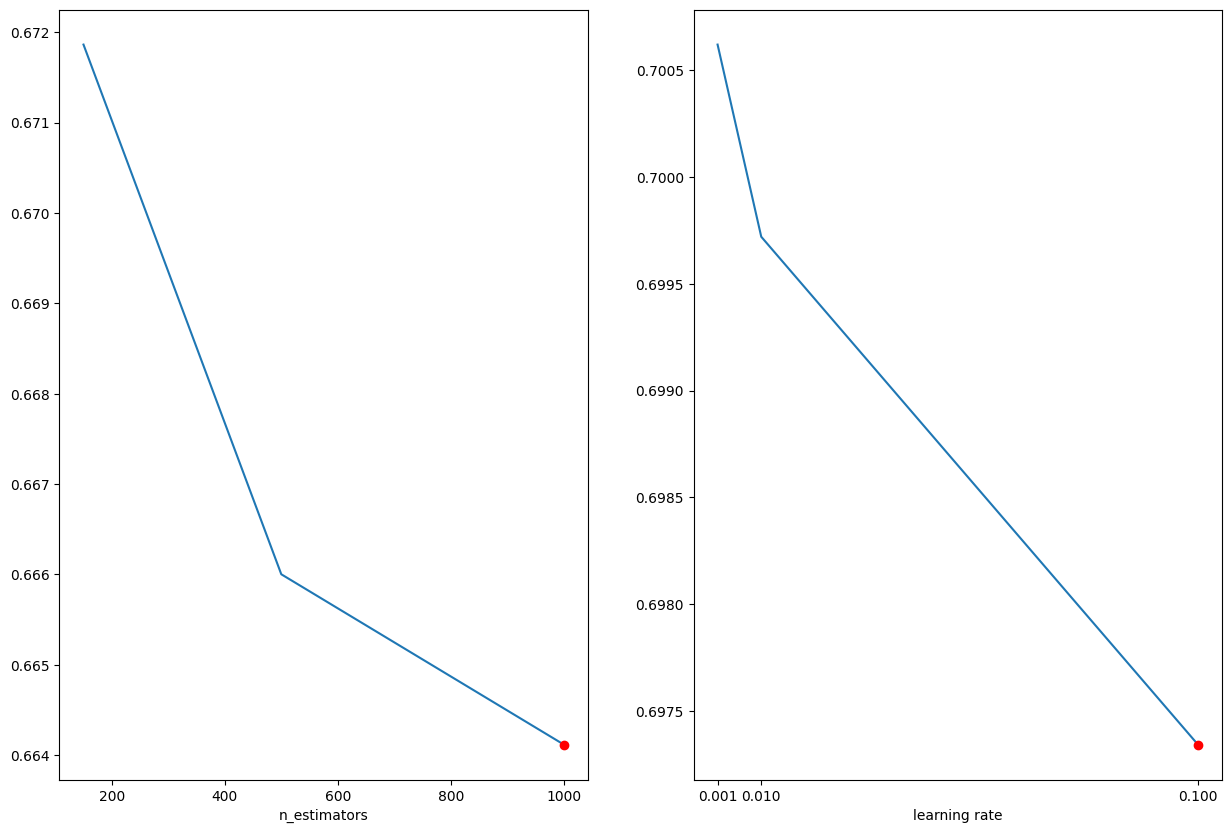

In [14]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows =1 ,ncols = 2,figsize=(15,10))
axs[0].plot(estimators,scores)
axs[0].plot(estimators[np.argmin(scores)],min(scores),'o',color='red')
axs[0].set_xlabel('n_estimators')
axs[1].plot(learningrate,scores2)
axs[1].plot(learningrate[np.argmin(scores2)],min(scores2),'o',color='red')
axs[1].set_xticks(learningrate)
axs[1].set_xlabel('learning rate')

In [15]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
model = AdaBoostRegressor (
    DecisionTreeRegressor( 
        random_state=123,max_depth = 10,max_features = 8),
    n_estimators = 1000,
    learning_rate = 0.1
)

scores = []
datasets = [X_train,X_transformed]
for i in datasets:
    sc = cross_validate(model, i, y, cv=cv,scoring=('neg_root_mean_squared_error'),return_train_score=True)
    scores.append(-sc['test_score'].mean())
scores

[0.6667084724686588, 0.6657084260253885]

In [16]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
scores2 = []
for i in ['square','exponential']:
    model2 = AdaBoostRegressor (
    DecisionTreeRegressor( 
        random_state=123,max_depth = 10,max_features = 8),
    n_estimators = 1000,
    learning_rate = 0.1,
    loss = i
)
    sc2 = cross_validate(model2, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'),return_train_score=True)
    scores2.append(-sc2['test_score'].mean())
scores2

[0.6666990831984394, 0.6676077194492769]

In [18]:
resultados2 = pd.DataFrame({'Modelos' : ['Función pérdida cuadrática','Función pérdida exponencial'],
                          'RMSE AdaBoost': scores2})
resultados2

,Modelos,RMSE AdaBoost
0,Función pérdida cuadrática,0.666699
1,Función pérdida exponencial,0.667608


**XGB Regressor**

In [45]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold,cross_validate
estimators = [150,500,1000]
scores = []
cv = KFold(n_splits = 10)
for i in estimators :
    modelo = XGBRegressor(n_estimators= i,learning_rate=0.1,max_depth=5,min_child_weight = 1,gamma = 0,scale_pos_weight = 1)
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc2['test_score'].mean())
    
scores

[0.667700565432638, 0.6840504486467869, 0.6874466686965346]

In [49]:
max_depth = range(3,10,2)
scores2 = []
cv = KFold(n_splits = 10)
for i in max_depth :
    modelo = XGBRegressor(n_estimators= 150,learning_rate=0.1,max_depth=i,min_child_weight = 1,gamma = 0,scale_pos_weight = 1)
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2.append(-sc2['test_score'].mean())
    
scores2

[0.6549200235340124, 0.667700565432638, 0.6740913655238592, 0.6885419079943416]

In [51]:
min_child_weight = range(1,6,2)
scores3 = []
cv = KFold(n_splits = 10)
for i in min_child_weight :
    modelo = XGBRegressor(n_estimators= 150,learning_rate=0.1,max_depth=3,min_child_weight = i,gamma = 0,scale_pos_weight = 1)
    sc3 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores3.append(-sc3['test_score'].mean())
    
scores3

[0.6549200235340124, 0.6570459512857425, 0.6553894983703223]

In [53]:
gamma = np.linspace(0,0.4,num=5)
scores4 = []
cv = KFold(n_splits = 10)
for i in gamma :
    modelo = XGBRegressor(n_estimators= 150,learning_rate=0.1,max_depth=3,min_child_weight = 5,gamma = i,scale_pos_weight = 1)
    sc4 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores4.append(-sc4['test_score'].mean())
    
scores4

[0.6553894983703223,
 0.6553894983703223,
 0.6569658434727651,
 0.6558479317528175,
 0.6539530072755454]

In [55]:
reg_alpha = [0, 0.001, 0.01, 0.1,0.5,0.8,1]
scores5 = []
cv = KFold(n_splits = 10)
for i in reg_alpha :
    modelo = XGBRegressor(n_estimators= 150,learning_rate=0.1,max_depth=3,min_child_weight = 5,gamma = 0.1,scale_pos_weight = 1,reg_alpha=i)
    sc5 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores5.append(-sc5['test_score'].mean())
    
scores5

[0.6553894983703223,
 0.6544632053318881,
 0.655065654677864,
 0.6547490199918329,
 0.6563517139470108,
 0.6539179817618452,
 0.6550998217837354]

Text(0.5, 0, 'reg_alpha')

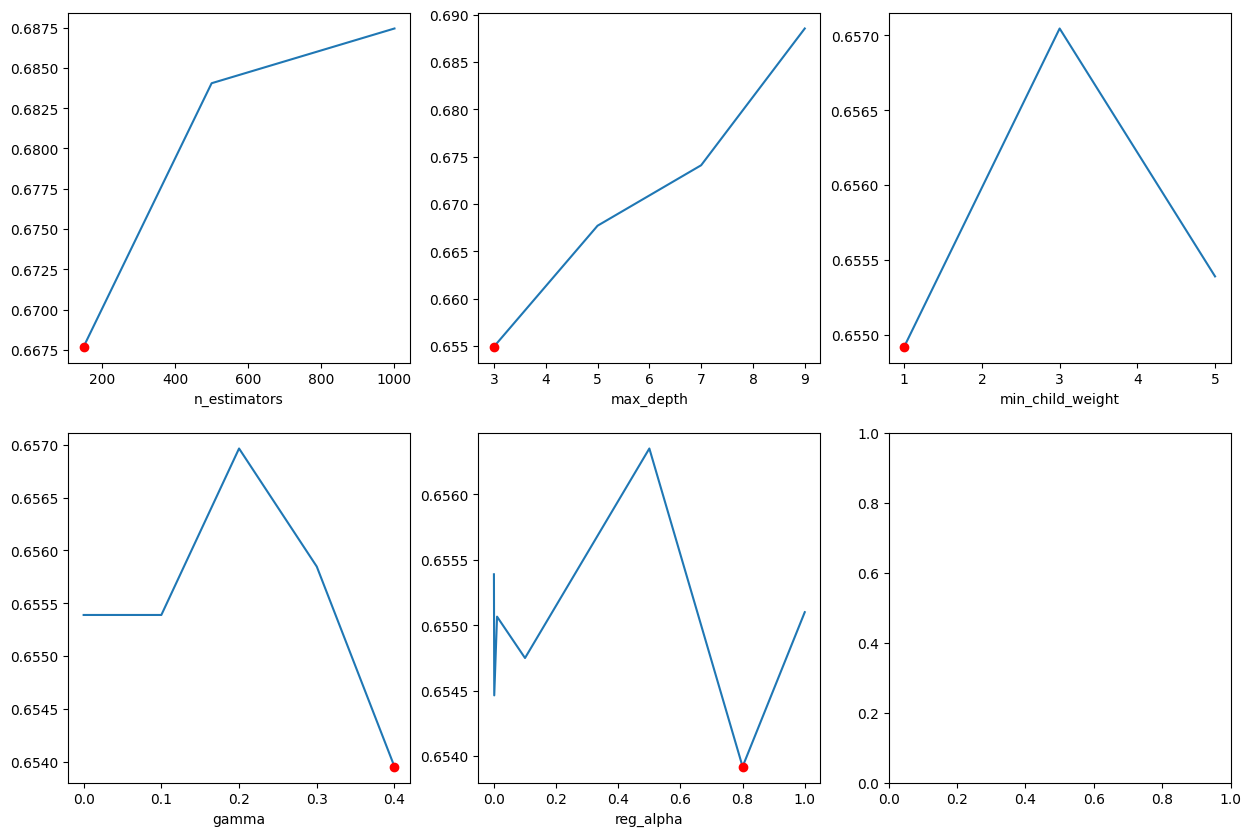

In [59]:
fig,axs = plt.subplots(nrows =2 ,ncols = 3,figsize=(15,10))
axs[0,0].plot(estimators,scores)
axs[0,0].plot(estimators[np.argmin(scores)],min(scores),'o',color='red')
axs[0,0].set_xlabel('n_estimators')
axs[0,1].plot(max_depth,scores2)
axs[0,1].plot(max_depth[np.argmin(scores2)],min(scores2),'o',color='red')
axs[0,1].set_xlabel('max_depth')
axs[0,2].plot(min_child_weight,scores3)
axs[0,2].plot(min_child_weight[np.argmin(scores3)],min(scores3),marker='o',color = 'red')
axs[0,2].set_xlabel('min_child_weight')
axs[1,0].plot(gamma,scores4)
axs[1,0].set_xlabel('gamma')
axs[1,0].plot(gamma[np.argmin(scores4)],min(scores4),'o',color='red')
axs[1,1].plot(reg_alpha,scores5)
axs[1,1].plot(reg_alpha[np.argmin(scores5)],min(scores5),'o',color='red')
axs[1,1].set_xlabel('reg_alpha')

In [86]:
from sklearn.model_selection import ParameterGrid
cv = KFold(n_splits=10)
param_grid = ParameterGrid(
                {'n_estimators': [150,500],
                 'max_depth': [2,3,4],
                 'min_child_weight'   : [3,5,7],
                 'gamma' : [0.1],
                 'reg_alpha': [0.1,0.5,1],
                 'learning_rate':[0.1],
                 'scale_pos_weight':[1]
                }
             )
resultados = {'params': [], 'rmse': []}

for params in param_grid:
    
    modelo = XGBRegressor(
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2=-sc2['test_score'].mean()
    resultados['params'].append(params)
    resultados['rmse'].append(scores2)
    print(f"Modelo: {params} , rmse: {scores2}✓")

Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0.1, 'scale_pos_weight': 1} , rmse: 0.6569317750455544✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0.5, 'scale_pos_weight': 1} , rmse: 0.6581474762082901✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 1, 'scale_pos_weight': 1} , rmse: 0.657794394300778✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'scale_pos_weight': 1} , rmse: 0.663777360884501✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0.5, 'scale_pos_weight': 1} , rmse: 0.6662603703492633✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 1, 'scale_pos_we

In [89]:
min(resultados['rmse'])

0.6534135986701288

In [99]:
from xgboost import XGBRegressor
#Modelo: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150, 'reg_alpha': 1, 'scale_pos_weight': 1}
#Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 150, 'reg_alpha': 0.1, 'scale_pos_weight': 1} , rmse: 0.6534135986701288✓
#model3 = XGBRegressor(n_estimators= 220,learning_rate=0.1,max_depth=5,min_child_weight = 1)
model3 = XGBRegressor(
                n_jobs       = -1,
                random_state = 123,
                gamma = 0.1,
                learning_rate = 0.1,
                max_depth= 3,
                min_child_weight = 7,
                reg_alpha = 0.1,
                n_estimators = 150
             )
scores3 = []
datasets = [X_train,X_transformed]
for i in datasets:
    sc3 = cross_validate(model3, i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores3.append(-sc3['test_score'].mean())

scores3

[0.6534135986701288, 0.6534135986701288]

In [100]:
resultados3 = pd.DataFrame({'Modelos' : ['Todas variables','Todas con transformación'],
                          'RMSE XGBRegressor': scores3})
resultados3

,Modelos,RMSE XGBRegressor
0,Todas variables,0.653414
1,Todas con transformación,0.653414


**LightGBM Regressor**

In [60]:
import lightgbm as lgb
from sklearn.model_selection import KFold,cross_validate
estimators = [100,150,200]# para 500 y 1000 ->  0.6957901148117934, 0.7076523497545165
scores = []
cv = KFold(n_splits = 10)
for i in estimators :
    modelo = lgb.LGBMRegressor(n_estimators= i,learning_rate=0.1,max_depth=5,reg_lambda = 0.1,reg_alpha=0.1,verbosity=-1)
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc2['test_score'].mean())
    
scores

[0.6598624326394609, 0.6625820761821088, 0.6673980259162704]

In [62]:
learning_rate = [0.01,0.1,1]
scores2 = []
cv = KFold(n_splits = 10)
for i in estimators :
    modelo = lgb.LGBMRegressor(n_estimators= 100,learning_rate=i,max_depth=5,reg_lambda = 0.1,reg_alpha=0.1,verbosity=-1)
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2.append(-sc2['test_score'].mean())
    
scores2

[6.176860115736067e+39, 9.939253184103613e+38, 9.15076525319893e+38]

In [64]:
max_depth = [2,3,4,5]
scores3 = []
cv = KFold(n_splits = 10)
for i in max_depth :
    modelo = lgb.LGBMRegressor(n_estimators= 100,learning_rate=0.1,max_depth=i,reg_lambda = 0.1,reg_alpha=0.1,verbosity=-1)
    sc3 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores3.append(-sc3['test_score'].mean())
    
scores3

[0.6594871729693065,
 0.6536388804481091,
 0.6576252680728512,
 0.6598624326394609]

In [66]:
reg_lambda = [0.01,0.1,1]
scores4 = []
cv = KFold(n_splits = 10)
for i in estimators :
    modelo = lgb.LGBMRegressor(n_estimators= 100,learning_rate=0.1,max_depth=3,reg_lambda = i,reg_alpha=0.1,verbosity=-1)
    sc4 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores4.append(-sc4['test_score'].mean())
    
scores4

[0.6610937241476257, 0.6634305984033905, 0.6646693351930661]

In [68]:
reg_alpha = [0.01,0.1,1]
scores5 = []
cv = KFold(n_splits = 10)
for i in reg_alpha :
    modelo = lgb.LGBMRegressor(n_estimators= 100,learning_rate=0.1,max_depth=3,reg_lambda = 0.01,reg_alpha=i,verbosity=-1)
    sc5 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores5.append(-sc5['test_score'].mean())
    
scores5

[0.6548687459466315, 0.6534619734136702, 0.653791390141262]

In [70]:
num_leaves = [10,20,31]
scores6 = []
cv = KFold(n_splits = 10)
for i in num_leaves :
    modelo = lgb.LGBMRegressor(n_estimators= 100,learning_rate=0.1,max_depth=3,reg_lambda = 0.01,reg_alpha=0.1,num_leaves=i,verbosity=-1)
    sc6 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores6.append(-sc6['test_score'].mean())
    
scores6

[0.6534619734136702, 0.6534619734136702, 0.6534619734136702]

In [71]:
min_child_samples = [10,20,31]
scores7 = []
cv = KFold(n_splits = 10)
for i in min_child_samples :
    modelo = lgb.LGBMRegressor(n_estimators= 150,learning_rate=0.1,max_depth=3,reg_lambda = 0.1,reg_alpha=0.1,min_child_samples=i,verbosity=-1)
    sc7 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores7.append(-sc7['test_score'].mean())
    
scores7

[0.6578952758899497, 0.6528304051116411, 0.6550969944546297]

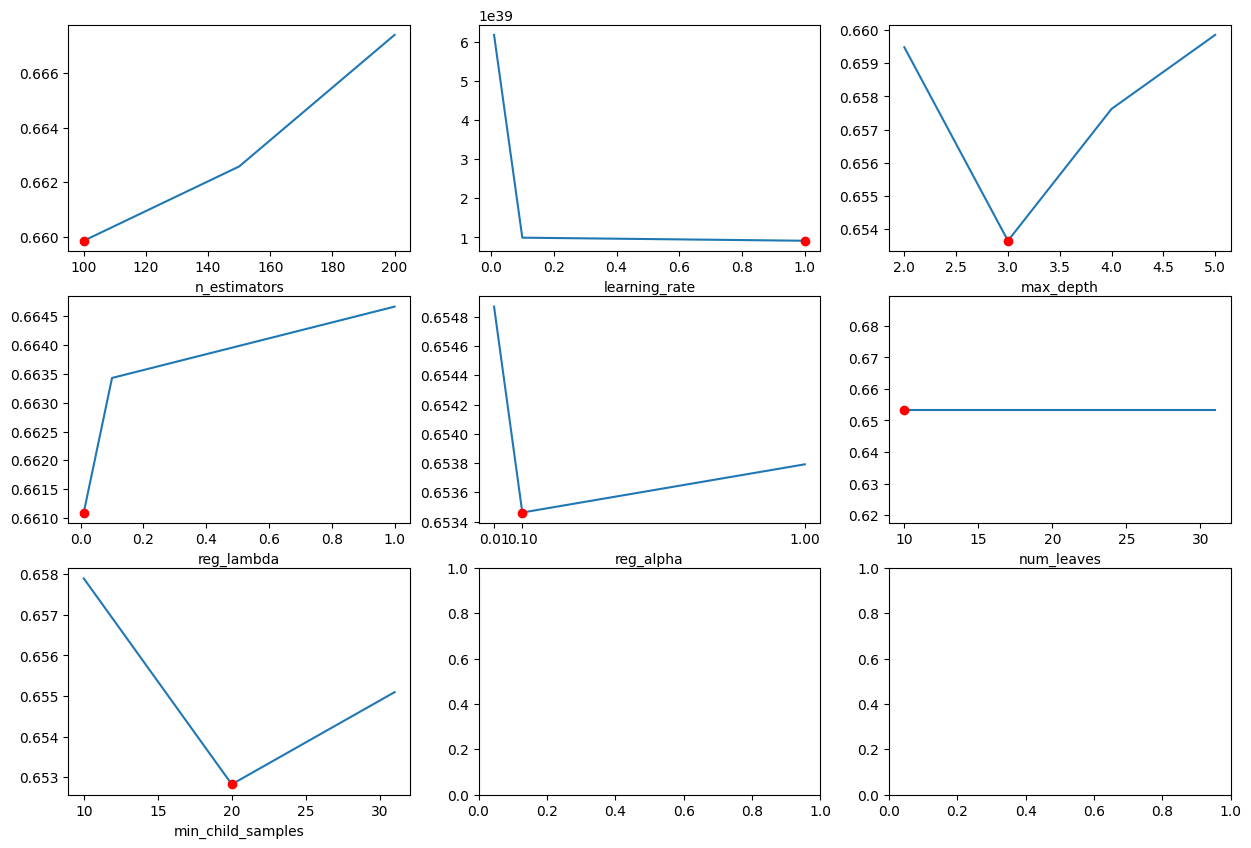

In [73]:
fig,axs = plt.subplots(nrows =3 ,ncols = 3,figsize=(15,10))
axs[0,0].plot(estimators,scores)
axs[0,0].plot(estimators[np.argmin(scores)],min(scores),'o',color='red')
axs[0,0].set_xlabel('n_estimators')
axs[0,1].plot(learning_rate,scores2)
axs[0,1].plot(learning_rate[np.argmin(scores2)],min(scores2),'o',color='red')
axs[0,1].set_xlabel('learning_rate')
axs[0,2].plot(max_depth,scores3)
axs[0,2].plot(max_depth[np.argmin(scores3)],min(scores3),marker='o',color = 'red')
axs[0,2].set_xlabel('max_depth')
axs[1,0].plot(reg_lambda,scores4)
axs[1,0].set_xlabel('reg_lambda')
axs[1,0].plot(reg_lambda[np.argmin(scores4)],min(scores4),'o',color='red')
axs[1,1].plot(reg_alpha,scores5)
axs[1,1].set_xticks(reg_alpha)
axs[1,1].plot(reg_alpha[np.argmin(scores5)],min(scores5),'o',color='red')
axs[1,1].set_xlabel('reg_alpha')
axs[1,2].plot(num_leaves,scores6)
axs[1,2].set_xlabel('num_leaves')
axs[1,2].plot(num_leaves[np.argmin(scores6)],min(scores6),'o',color='red')
axs[2,0].plot(min_child_samples,scores7)
axs[2,0].set_xlabel('min_child_samples')
axs[2,0].plot(min_child_samples[np.argmin(scores7)],min(scores7),'o',color='red')

In [113]:
from sklearn.model_selection import ParameterGrid
cv = KFold(n_splits=10)
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_depth': [3,5],
                 'reg_alpha': [0.01,0.1],
                 'reg_lambda': [0.01,0.1],
                 'learning_rate':[0.1],
                 'min_child_samples':[10,20,31],
                 'num_leaves':[10,20,31]
                }
             )
resultados = {'params': [], 'rmse': []}

for params in param_grid:
    
    modelo = lgb.LGBMRegressor(objective= "regression",
                               metric= "rmse",
                               random_state = 123,
                               verbosity= -1,
                               **params)
    
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2=-sc2['test_score'].mean()
    resultados['params'].append(params)
    resultados['rmse'].append(scores2)
    print(f"Modelo: {params} , rmse: {scores2}✓")

Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 150, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 0.01} , rmse: 0.6566661699166001✓
Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 150, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 0.1} , rmse: 0.6577570727237562✓
Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 150, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.01} , rmse: 0.6560436414961839✓
Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 150, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1} , rmse: 0.6565197917282654✓
Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 150, 'num_leaves': 20, 'reg_alpha': 0.01, 'reg_lambda': 0.01} , rmse: 0.6566661699166001✓
Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 150, 'num_leaves': 20, 're

In [114]:
min(resultados['rmse'])
#Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 150, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.01} , rmse: 0.6624519528725951✓
#Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 150, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1} , rmse: 0.6528449741514809✓
#Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 150, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.01} , rmse: 0.6624519528725951✓
#Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 150, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1} , rmse: 0.6528449741514809✓
#Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 150, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.01} , rmse: 0.6624519528725951✓
#Modelo: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 150, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.1} , rmse: 0.6528449741514809✓

0.6528449741514809

In [117]:
import lightgbm as lgb
from sklearn.model_selection import KFold,cross_validate
cv = KFold(n_splits = 10)
model4 = lgb.LGBMRegressor(objective= "regression",
                               metric= "rmse",
                               random_state = 123,
                               verbosity= -1,
                               n_estimators = 150,
                               learning_rate = 0.1,
                               max_depth = 3,
                               min_child_samples = 20,
                               reg_alpha = 0.1,
                               reg_lambda= 0.1,
                               num_leaves = 20)
scores4 = []
datasets = [X_train,X_transformed]
for i in datasets:
    sc4 = cross_validate(model4, i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores4.append(-sc4['test_score'].mean())

scores4

[0.6562836206851509, 0.6528449741514809]

In [119]:
resultados4 = pd.DataFrame({'Modelos' : ['Todas variables','Todas con transformación'],
                          'RMSE LightGBM': scores4})
resultados4

,Modelos,RMSE LightGBM
0,Todas variables,0.656284
1,Todas con transformación,0.652845


**CatBoost Regressor**

In [46]:
def DatFeatures(df):
    dataframe = n_input(df)
    features = [len_input,n_nonprod,len_nonprod,n_remove,len_remove,
               n_replace,len_replace,n_events,n_words,
                act_time,writing_time,punct,numfrases_intervalo,cursor_position_mean,n_remove2,n_parrafos,n_space,n_dropenter]
    
    for fun in features:
        prev_dat = fun(df).fillna(0)
        dataframe = dataframe.merge(prev_dat,on='id',how='left').fillna(0)
    dataframe['pausa'] = dataframe['writing_time'] - dataframe['act_time']
    dataframe['prop_pausa'] = dataframe['pausa']/dataframe['writing_time']
    dataframe['time_by_word'] = (dataframe['writing_time']/dataframe['word_count']).replace([np.inf, np.inf],500000)
    dataframe['productivity'] = dataframe['act_time']/dataframe['writing_time']*100
#    dataframe['n_caracteres'] = dataframe['n_input'] - dataframe['n_remove']
    dataframe['n_caracteres2'] = dataframe['n_input'] - dataframe['n_remove2']
    dataframe['n_parrafos2'] = dataframe['n_parrafos'] - dataframe['n_dropenter']
    dataframe = dataframe.drop(['n_parrafos','n_dropenter'],axis=1)
    return dataframe

In [74]:
import catboost as cb
from sklearn.model_selection import KFold,cross_validate
estimators = [150,500,1000]
scores = []
cv = KFold(n_splits = 10)
for i in estimators :
    modelo = cb.CatBoostRegressor(n_estimators= i,learning_rate = 0.01,silent = True)
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc2['test_score'].mean())
    
scores

[0.7182073539112881, 0.6634797145578453, 0.6542116295059336]

In [77]:
import catboost as cb
depth = [3,4,5,6,7,8]
scores2 = []
cv = KFold(n_splits = 10)
for i in depth :
    modelo = cb.CatBoostRegressor(n_estimators= 100,learning_rate = 0.1,depth = i,silent = True)
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2.append(-sc2['test_score'].mean())
    
scores2

[0.6619962993277854,
 0.6576564721487089,
 0.6582001305542666,
 0.6590738335785128,
 0.6616526290468272,
 0.6632116581011194]

In [79]:
import catboost as cb
reg_lambda = [0.1,0.01,1]
scores3 = []
cv = KFold(n_splits = 10)
for i in reg_lambda :
    modelo = cb.CatBoostRegressor(n_estimators= 100,learning_rate = 0.1,depth = 6,reg_lambda = i,silent = True,
                                 early_stopping_rounds=25, od_type='Iter', eval_metric = 'RMSE')
    sc3 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores3.append(-sc3['test_score'].mean())
    
scores3#[0.6631327676017389, 0.6634031338937849, 0.6643697612401823]

[0.6611165517280564, 0.6590962520641832, 0.6612561480061515]

Text(0.5, 0, 'reg_lambda')

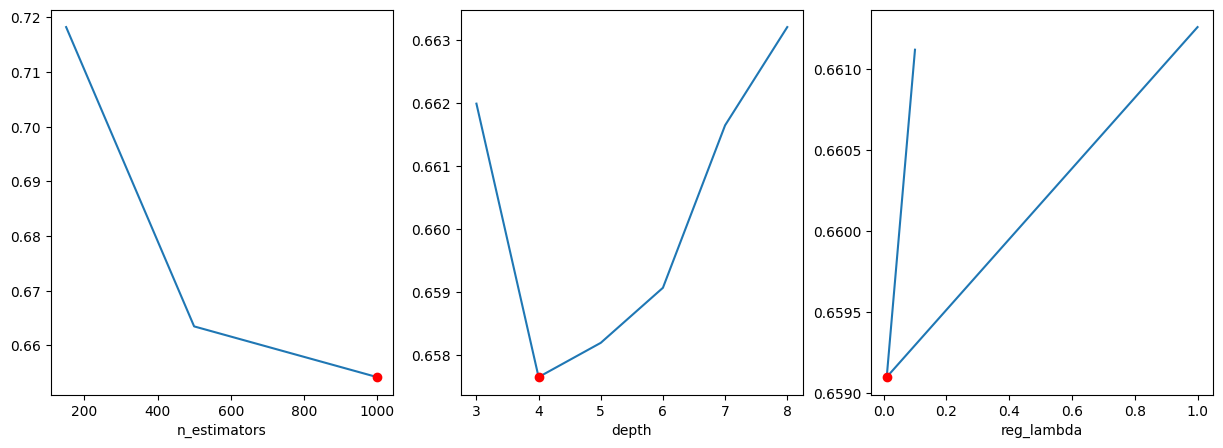

In [85]:
fig,axs = plt.subplots(nrows =1 ,ncols = 3,figsize=(15,5))
axs[0].plot(estimators,scores)
axs[0].plot(estimators[np.argmin(scores)],min(scores),'o',color='red')
axs[0].set_xlabel('n_estimators')
axs[1].plot(depth,scores2)
axs[1].plot(depth[np.argmin(scores2)],min(scores2),'o',color='red')
axs[1].set_xlabel('depth')
axs[2].plot(reg_lambda,scores3)
axs[2].plot(reg_lambda[np.argmin(scores3)],min(scores3),marker='o',color = 'red')
axs[2].set_xlabel('reg_lambda')

In [42]:
from sklearn.model_selection import ParameterGrid
cv = KFold(n_splits=10)
param_grid = ParameterGrid(
                {'n_estimators': [1000],
                 'depth': [4,5,6],
                 'reg_lambda': [0.01,0.1],
                 'learning_rate':[0.01],
                }
             )
resultados = {'params': [], 'rmse': []}

for params in param_grid:
    
    modelo = cb.CatBoostRegressor(silent = True,early_stopping_rounds=25, od_type='Iter', eval_metric = 'RMSE', random_state = 123,
                               **params)
    
    sc2 = cross_validate(modelo, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2=-sc2['test_score'].mean()
    resultados['params'].append(params)
    resultados['rmse'].append(scores2)
    print(f"Modelo: {params} , rmse: {scores2}✓")

Modelo: {'depth': 4, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.01} , rmse: 0.6547068492994249✓
Modelo: {'depth': 4, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.1} , rmse: 0.6548089992789523✓
Modelo: {'depth': 5, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.01} , rmse: 0.6532602371226781✓
Modelo: {'depth': 5, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.1} , rmse: 0.652671395990006✓
Modelo: {'depth': 6, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.01} , rmse: 0.6530429217848305✓
Modelo: {'depth': 6, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.1} , rmse: 0.653221379484201✓


In [45]:
min(resultados['rmse'])#Modelo: {'depth': 5, 'learning_rate': 0.01, 'n_estimators': 1000, 'reg_lambda': 0.1} , rmse: 0.652671395990006✓

0.652671395990006

In [40]:
import catboost as cb
model5 = cb.CatBoostRegressor(iterations = 1000, learning_rate = 0.01, depth = 5, reg_lambda = 0.1, silent=True,
                             early_stopping_rounds=25, od_type='Iter', eval_metric = 'RMSE', random_state = 123)

scores5 = []
sc5 = cross_validate(model5, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
scores5.append(-sc5['test_score'].mean())

scores5

[0.6510815024888292]